In [23]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
from source.tserie import TSerie
from source.read_ontario import read_ontario, read_ontario_stations
from source.utils import commonWindows
from source.torch_utils import getContrastiveFeatures
from cuml.manifold import UMAP
# from ccpca import CCPCA

VIS_PATH = 'visualizations'
SMOOTH = 8 # 8 -1 if you don't want to smooth the data otherwise the size of the smooth window
LOSS = 'SimCLR' # SupConLoss | SimCLR
MODE = 'subsequences' # subsequences - shape
# MODE = 'shape' # subsequences - shape
EPOCHS = 40
BATCH_SIZE = 128
ENC_SIZE = 8 # 8
POLLUTANTS = ['PM25', 'CO', 'NO'] # ['NO', 'NOx', 'NO2', 'SO2', 'CO', 'O3', 'PM25']
CONV_FILTERS = [16, 32]
CONV_KERNELS = [7, 7]
UMAP_NEIGHBORS = 15
N_VIZ_SAMPLES = 600

# Months case

In [24]:
windows_map = read_ontario(granularity='months', cache=True)

data_info = read_ontario_stations()
pollutans = POLLUTANTS
# windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

In [25]:
# windows_map['SO2'][13001]['2010-1'][0].shape
# windows_map
windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

windows.shape

In [31]:
# windows.shape
# data_info
# station_ids
# stations
# dates.shape

# data_info
# data_info[str(stations[station_ids[0]])]

{'46089': {'name': 'Brampton',
  'latitude': '43.69875',
  'longitude': '-79.780917'},
 '44008': {'name': 'Burlington',
  'latitude': '43.315111',
  'longitude': '-79.802639'},
 '56051': {'name': 'Cornwall',
  'latitude': '45.017972',
  'longitude': '-74.735222'},
 '49010': {'name': 'Dorset',
  'latitude': '45.224278',
  'longitude': '-78.932944'},
 '15020': {'name': 'Grand Bend',
  'latitude': '43.333083',
  'longitude': '-81.742889'},
 '28028': {'name': 'Guelph',
  'latitude': '43.551611',
  'longitude': '-80.264167'},
 '29000': {'name': 'Hamilton Downtown',
  'latitude': '43.257778',
  'longitude': '-79.861667'},
 '29114': {'name': 'Hamilton Mountain',
  'latitude': '43.229417',
  'longitude': '-79.862778'},
 '29118': {'name': 'Hamilton West',
  'latitude': '43.257444',
  'longitude': '-79.90775'},
 '52020': {'name': 'Kingston',
  'latitude': '44.265698',
  'longitude': '-76.5017756'},
 '26060': {'name': 'Kitchener',
  'latitude': '43.443833',
  'longitude': '-80.503806'},
 '15025':

In [5]:
month_ids = np.array([date.month for date in dates])
year_ids = np.array([date.year for date in dates])


stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, 13)}
years_map = {int(year) : str(year) for year in year_ids}
coords = np.array([
    [
        float(data_info[str(stations[station_ids[i]])]['latitude']), 
        float(data_info[str(stations[station_ids[i]])]['longitude'])
    ]
    for i in range(len(windows))
])

In [6]:
# dates
import datetime

epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0

# unix_time_millis(dates[0])

timeInMs = np.array([unix_time_millis(d) for d in dates])
timeInMs = np.expand_dims(timeInMs, axis=1)


In [7]:
mts = TSerie(X=windows, y = station_ids)

if SMOOTH > 0:
    mts.smooth(window_size=SMOOTH)

if MODE == 'shape':
    mts.shapeNormalizization()
else:
    mts.minMaxNormalizization()


Loaded mts - N: 1172, T: 28, D: 3 
(1172, 3, 28)


In [8]:
from source.featlearn.autoencoder_lr import AutoencoderFL, DCEC, VAE_FL

cae = AutoencoderFL(mts.D, mts.T, feature_size=10)
# cae = DCEC(mts.D, mts.T, feature_size=10, n_clusters=5)
# cae = VAE_FL(mts.D, mts.T, feature_size=10)

cae.fit(mts.X, epochs=1400, batch_size=320)
# cae.fit(mts.X, epochs=1000, batch_size=320, gamma=0)

Epoch[1] Train loss    avg: 0.41125161945819855
Epoch[50] Train loss    avg: 0.0056793405674397945
Epoch[100] Train loss    avg: 0.003232437593396753
Epoch[150] Train loss    avg: 0.0023074577911756933
Epoch[200] Train loss    avg: 0.002014938014326617
Epoch[250] Train loss    avg: 0.0015648615662939847
Epoch[300] Train loss    avg: 0.001810238987673074
Epoch[350] Train loss    avg: 0.0012470784422475845
Epoch[400] Train loss    avg: 0.0011630907538346946
Epoch[450] Train loss    avg: 0.0011711777042364702
Epoch[500] Train loss    avg: 0.0010057050094474107
Epoch[550] Train loss    avg: 0.0010388082882855088
Epoch[600] Train loss    avg: 0.0008923497225623578
Epoch[650] Train loss    avg: 0.00083423093019519
Epoch[700] Train loss    avg: 0.0008537168323528022
Epoch[750] Train loss    avg: 0.0007814483833499253
Epoch[800] Train loss    avg: 0.000757705929572694
Epoch[850] Train loss    avg: 0.0007772473036311567
Epoch[900] Train loss    avg: 0.0007952532032504678
Epoch[950] Train loss  

In [9]:
from source.featlearn.autoencoder_lr import AutoencoderFL, DCEC

# cae.fit(mts.X, epochs=1000, batch_size=320, gamma=100)
# rec, mts.features, clusters = cae.encode(mts.X)
rec, mts.features = cae.encode(mts.X)


In [10]:
# coords.shape
# timeInMs.shape
# mts.features.shape


In [20]:
from sklearn.metrics import pairwise_distances

delta = 0.1
beta = 0.

space_DM = pairwise_distances(coords)
space_DM = space_DM / np.max(space_DM)

feature_DM = pairwise_distances(mts.features, metric='cosine')
feature_DM = feature_DM / np.max(feature_DM)


time_DM = pairwise_distances(timeInMs)
time_DM = time_DM / np.max(time_DM)

# distM = feature_DM * (1 - delta) + space_DM * delta
distM = feature_DM * (1 - (delta + beta)) + space_DM * delta + time_DM * beta
# mts.features = np.concatenate([mts.features, coords], axis=1)

In [21]:
# # # clusters
# preds = np.argmax(clusters, axis=1)
# print(np.unique(preds, return_counts=True))

/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


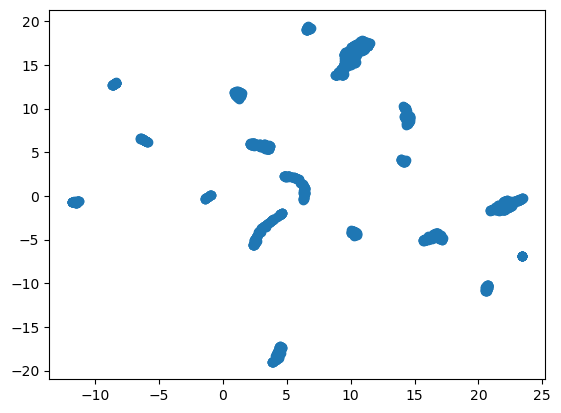

In [22]:
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# reducer = umap.UMAP(n_components=2, metric='euclidean')
reducer = umap.UMAP(n_components=2, metric='precomputed')
# reducer = TSNE(n_components=2, metric='precomputed')

# reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.1, metric='cosine')
# reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.1)
# reducer = TSNE(n_components=2, metric='euclidean')

# coords = reducer.fit_transform(mts.features, y = month_ids)
# coords = reducer.fit_transform(mts.features)
coords = reducer.fit_transform(distM)

# plt.scatter(coords[:, 0], coords[:, 1], c=preds)
plt.scatter(coords[:, 0], coords[:, 1])

In [14]:
import matplotlib.pyplot as plt

def plot1d(x, x2=None, x3=None, ylim=(-1, 1), save_file=""):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 3))
    steps = np.arange(x.shape[0])
    plt.plot(steps, x)
    if x2 is not None:
        plt.plot(steps, x2)
    if x3 is not None:
        plt.plot(steps, x3)
    plt.xlim(0, x.shape[0])
    # plt.ylim(ylim)
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file, "")
    else:
        plt.show()
    return

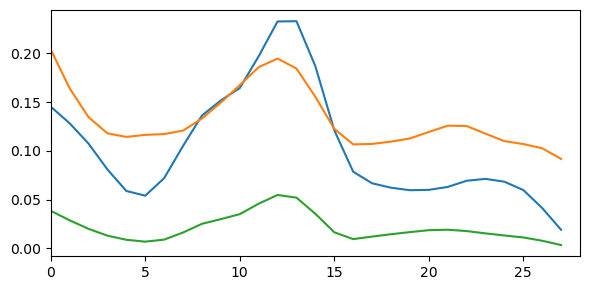

In [15]:
pos = 90
plot1d(mts.X[pos])

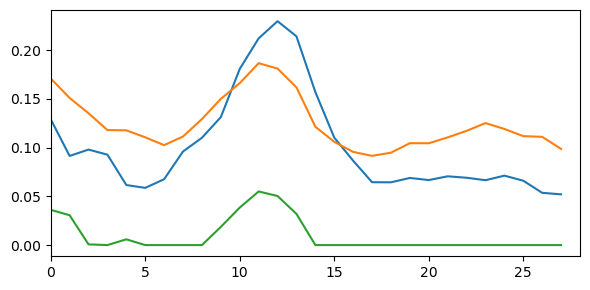

In [16]:
plot1d(rec[pos])